In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = "../data/laks"

In [31]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_processors.ov2295_data import OV2295_Data_Preprocessor
from evaluate.hypothesis_test import *
from scope.phylogeny_utils import *

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
    "axes.linewidth": 1,  # thin axes
    "lines.linewidth": 1, # thin box lines
    "grid.color": "none",  # no grid
    "xtick.major.width": 1,
    "ytick.major.width": 1,
})


In [4]:
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

In [5]:
ov2295 = OV2295_Data_Preprocessor(DATA_DIR=DATA_DIR)

In [7]:
gt_cell_mutation_cn = ov2295.get_cell_mutation_cn_state()
gt_cell_mutation_cn

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id_x,bin_start,sample_id_y,library_id,chr,start,end,reads,copy,state,mutation,clone_id
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,2,1.000000,1,1:19671432:C:T,NaN
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,776,1.944033,2,1:19671432:C:T,H
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,854,2.325511,2,1:19671432:C:T,H
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,19500001,SA921,A90554A,1,19500001,20000000,663,1.979604,2,1:19671432:C:T,NaN
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,19500001,SA921,A90554A,1,19500001,20000000,530,1.829550,2,1:19671432:C:T,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,209,0.988248,1,5:62716827:T:A,D
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,384,0.924362,1,5:62716827:T:A,C
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,456,1.219741,1,5:62716827:T:A,A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,62500001,SA1090,A96213A,5,62500001,63000000,269,1.061080,1,5:62716827:T:A,C


### Hypothesis Test on SCOPE phylogeny

In [24]:
scope_mutation_group_labels = pd.read_csv("../outputs/scope/laks/mutation_clusters/scope_clusters.csv")

In [25]:
alt_counts_scope, total_counts_scope = get_alt_and_total_counts_for_cn_cluster_mutation_group(gt_cell_mutation_cn, scope_mutation_group_labels)

In [26]:
pvals_scope = hypothesis_test(alt_counts_scope, total_counts_scope)

In [27]:
pvals_scope_combined = combine_weighted_pvalues(pvals_scope, total_counts_scope)

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


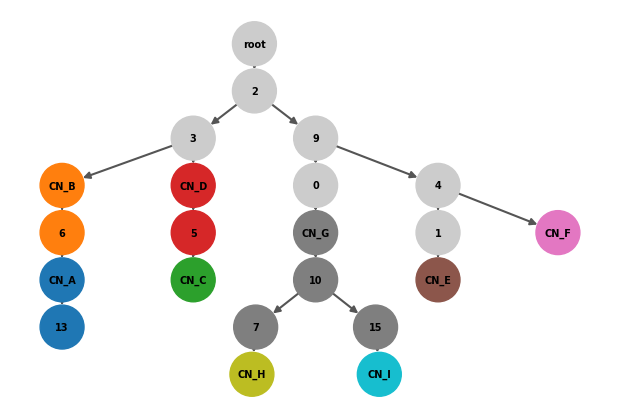

In [28]:
scope_tree = nx.read_edgelist("../outputs/scope/laks/scopetree.edgelist", create_using=nx.DiGraph)
draw_clone_tree(scope_tree)


In [37]:
num_clusters, num_mutation_groups = pvals_scope_combined.shape
row_cols_to_check = []
for i, cluster in enumerate(string.ascii_uppercase[:num_clusters], start=1):
    for j in range(num_mutation_groups):
        if not scope_tree.has_node(str(j)): continue
        if nx.has_path(scope_tree, str(j), f"CN_{cluster}"):
            row_cols_to_check.append((i - 1, j))

In [41]:
for copy_number in range(1, MAX_COPY_NUMBER):
    for row, col in row_cols_to_check:
        is_rejected = pvals_scope[copy_number, row, col] < 0.05
        if is_rejected:
            print(row, col, "Copy Number:", copy_number, "\tCN:", chr(ord('A') + row), "\tTotal Counts", total_counts_scope[copy_number, row, col], 
                 "\tAlt Counts", alt_counts_scope[copy_number, row, col], "\tCluster:", col, "\tp", 
                  pvals_scope[copy_number, row, col],
                   "\tX" if is_rejected else "")

0 2 Copy Number: 1 	CN: A 	Total Counts 5054 	Alt Counts 4713 	Cluster: 2 	p 3.591519867951461e-07 	X
0 3 Copy Number: 1 	CN: A 	Total Counts 1584 	Alt Counts 1428 	Cluster: 3 	p 2.0909187525738133e-10 	X
0 6 Copy Number: 1 	CN: A 	Total Counts 1638 	Alt Counts 1491 	Cluster: 6 	p 2.2248548988123706e-09 	X
1 2 Copy Number: 1 	CN: B 	Total Counts 3813 	Alt Counts 3544 	Cluster: 2 	p 1.7778016509120667e-07 	X
1 3 Copy Number: 1 	CN: B 	Total Counts 1352 	Alt Counts 1244 	Cluster: 3 	p 4.5705874626875524e-08 	X
2 2 Copy Number: 1 	CN: C 	Total Counts 4635 	Alt Counts 4111 	Cluster: 2 	p 5.724838139791781e-13 	X
2 3 Copy Number: 1 	CN: C 	Total Counts 1532 	Alt Counts 1411 	Cluster: 3 	p 4.686726294977094e-08 	X
2 5 Copy Number: 1 	CN: C 	Total Counts 1215 	Alt Counts 953 	Cluster: 5 	p 3.106569288995366e-25 	X
3 2 Copy Number: 1 	CN: D 	Total Counts 5569 	Alt Counts 4857 	Cluster: 2 	p 4.802129117404983e-15 	X
3 3 Copy Number: 1 	CN: D 	Total Counts 1852 	Alt Counts 1657 	Cluster: 3 	p 2.

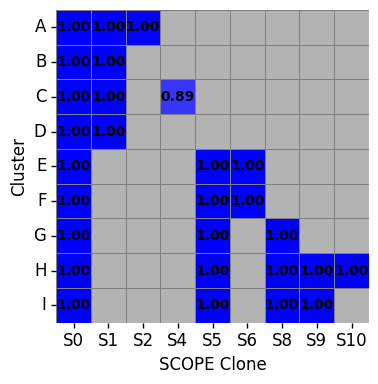

In [ ]:
df = pd.DataFrame(pvals_scope_combined, index=list("ABCDEFGHI"))


def format_pval(p, threshold=0.01):
    if p < threshold:
        return f"<{threshold:.2f}"
    else:
        return f"{p:.2f}"


row_cols_set = set(row_cols_to_check)

mask = np.ones(df.shape, dtype=bool)
for i, j in row_cols_set:
    if i < df.shape[0] and j < df.shape[1]:  # safety check
        mask[i, j] = False  # show these cells

mask_df = pd.DataFrame(mask, index=df.index, columns=df.columns)
# col_order = [2, 3, 6, 13, 5, 9, 4, 1, 0, 10, 7, 15]
col_order = [2, 3, 6, 5, 9, 4, 0, 10, 7]
df = df.reindex(columns=col_order)
mask_df = mask_df.reindex(columns=col_order)
mask = mask_df.to_numpy()

df_formatted = df.map(format_pval)


cmap = LinearSegmentedColormap.from_list("red_white_blue", ["red", "white", "blue"])
plt.figure(figsize=(6, 4))
sns.heatmap(
    df, 
    annot=df_formatted, 
    fmt='',
    cmap=cmap,
    mask=mask,             # mask cells not in row_cols
    cbar_kws={'label': 'p-value'},
    linewidths=0.5,        # optional grid lines
    linecolor='gray',
    vmin=0,              # force colormap to span 0->1
    vmax=1,
    annot_kws={"weight": "bold", "fontsize": 10, 'color': 'black'},
    cbar=False,
)

mask = np.flip(mask, axis=0)
plt.imshow( mask, cmap=plt.cm.Greys, alpha=mask * 0.3, zorder=-1, extent=[0, df.shape[1], 0, df.shape[0]] )

# plt.gca().set_xticklabels([f"S{i}" for i in range(df.shape[1])])
plt.gca().set_xticklabels([f"S{i}" for i in range(12) if i not in [3, 7, 11]])

plt.yticks(rotation=0)
plt.xlabel("SCOPE Clone")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig("../outputs/figures/scope-p-values.png", dpi=600, bbox_inches='tight',pad_inches=0.2)


### Hypothesis Test on Phertilizer Phylogeny

In [46]:
phertilizer_snv_clusters = pd.read_csv("../outputs/phertilizer-outputs/laks/SNV_clusters.csv")
phertilizer_snv_clusters['mutation'] = phertilizer_snv_clusters['mutation'].str.split('_').str[1]
phertilizer_snv_clusters.rename(columns={'cluster': 'mutation_group'}, inplace=True)
phertilizer_snv_clusters

,mutation_group,mutation
0,7,10:100129846:C:A
1,7,10:100185101:A:G
2,0,10:100209326:T:C
3,7,10:100283942:C:T
4,5,10:10086005:G:T
...,...,...
13827,2,X:98278474:C:A
13828,4,X:98452192:T:C
13829,0,X:98700894:C:T
13830,7,X:99136386:C:T


In [47]:
alt_counts_phertilizer, total_counts_phertilizer = get_alt_and_total_counts_for_cn_cluster_mutation_group(gt_cell_mutation_cn, phertilizer_snv_clusters)

In [48]:
pvals_phertilizer = hypothesis_test(alt_counts_phertilizer, total_counts_phertilizer)

In [49]:
pvals_phertilizer_combined = combine_weighted_pvalues(pvals_phertilizer, total_counts_phertilizer)

In [57]:
clonal_relations = [
    ('A', [0, 1, 3, 5, 6]), 
    ('B', [0, 1, 3, 5]), 
    ('C', [0, 1, 3, 4]), 
    ('D', [0, 1, 3, 4]), 
    ('E', [0, 7, 8]), 
    ('F', [0, 7, 9]), 
    ('G', [0, 1, 2]), 
    ('H', [0, 1, 2]), 
    ('I', [0, 1, 2]), 
]

row_cols_to_check_for_phertilizer = []
for cluster, clones in clonal_relations:
    for clone in clones:
        row_cols_to_check_for_phertilizer.append((ord(cluster) - ord('A'), clone))

In [58]:
for copy_number in range(1, MAX_COPY_NUMBER):
    for row, col in row_cols_to_check_for_phertilizer:
        is_rejected = pvals_phertilizer[copy_number, row, col] < 0.05
        if is_rejected:
            print("Copy Number:", copy_number, "\tCN:", chr(ord('A') + row), "\tCluster:", col, "\tp", pvals_phertilizer[copy_number, row, col], "\tTotal Reads", total_counts_phertilizer[copy_number, row, col], "\tX" if is_rejected else "")


Copy Number: 1 	CN: A 	Cluster: 0 	p 4.781936397016052e-31 	Total Reads 6653 	X
Copy Number: 1 	CN: A 	Cluster: 1 	p 7.698429928108293e-40 	Total Reads 177 	X
Copy Number: 1 	CN: A 	Cluster: 3 	p 1.078739054315534e-10 	Total Reads 2328 	X
Copy Number: 1 	CN: A 	Cluster: 5 	p 2.5625423888971873e-09 	Total Reads 1757 	X
Copy Number: 1 	CN: A 	Cluster: 6 	p 5.077507114248023e-20 	Total Reads 411 	X
Copy Number: 1 	CN: B 	Cluster: 0 	p 7.857843432933543e-31 	Total Reads 4978 	X
Copy Number: 1 	CN: B 	Cluster: 1 	p 1.0288373815772445e-21 	Total Reads 88 	X
Copy Number: 1 	CN: B 	Cluster: 3 	p 6.739603602140905e-10 	Total Reads 1867 	X
Copy Number: 1 	CN: B 	Cluster: 5 	p 1.938307856931213e-33 	Total Reads 1341 	X
Copy Number: 1 	CN: C 	Cluster: 0 	p 9.59526981028976e-31 	Total Reads 5849 	X
Copy Number: 1 	CN: C 	Cluster: 1 	p 1.7898658604164016e-31 	Total Reads 121 	X
Copy Number: 1 	CN: C 	Cluster: 3 	p 1.0875074311303521e-13 	Total Reads 2210 	X
Copy Number: 1 	CN: C 	Cluster: 4 	p 3.052

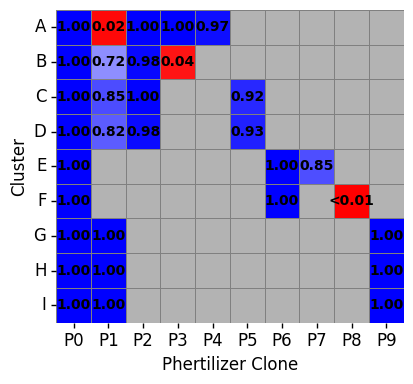

In [ ]:
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
    "axes.linewidth": 1,  # thin axes
    "lines.linewidth": 1, # thin box lines
    "grid.color": "none",  # no grid
    "xtick.major.width": 1,
    "ytick.major.width": 1,
})

df = pd.DataFrame(pvals_phertilizer_combined, index=list("ABCDEFGHI"))


def format_pval(p, threshold=0.01):
    if p < threshold:
        return f"<{threshold:.2f}"
    else:
        return f"{p:.2f}"


row_cols_set = set(row_cols_to_check_for_phertilizer)

# Create mask: True for cells to **hide** (gray out)
mask = np.ones(df.shape, dtype=bool)
for i, j in row_cols_set:
    if i < df.shape[0] and j < df.shape[1]:  # safety check
        mask[i, j] = False  # show these cells

mask_df = pd.DataFrame(mask, index=df.index, columns=df.columns)
col_order = [0, 1, 3, 5, 6, 4, 7, 8, 9, 2]
# col_order = [0, 1, 3, 5, 7]
df = df.reindex(columns=col_order)
mask_df = mask_df.reindex(columns=col_order)
mask = mask_df.to_numpy()

df_formatted = df.map(format_pval)


cmap = LinearSegmentedColormap.from_list("red_white_blue", ["red", "white", "blue"])
# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    df, 
    annot=df_formatted, 
    fmt='',
    cmap=cmap,
    mask=mask,             # mask cells not in row_cols
    cbar_kws={'label': 'p-value'},
    linewidths=0.5,        # optional grid lines
    linecolor='gray',
    vmin=0,              # force colormap to span 0->1
    vmax=1,
    annot_kws={"weight": "bold", "fontsize": 10, 'color': 'black'},
    cbar=False,
)

mask = np.flip(mask, axis=0)
plt.imshow( mask, cmap=plt.cm.Greys, alpha=mask * 0.3, zorder=-1, extent=[0, df.shape[1], 0, df.shape[0]] )

plt.gca().set_xticklabels([f"P{i}" for i in range(df.shape[1])])
# plt.gca().set_xticklabels([f"P{i}" for i in range(10) if i not in (4, 5, 7, 8, 9)])

plt.yticks(rotation=0)
plt.xlabel("Phertilizer Clone")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig("../outputs/figures/phertilizer-p-values.png", dpi=600, bbox_inches='tight',pad_inches=0.2)
plt.show()


### Hypothesis Test on Laks et al. Phylogeny

In [61]:
df_laks_tree = pd.read_csv("../data/laks/ov2295_nodes.csv.gz")

In [63]:
df_laks_tree_mut_origin = df_laks_tree.loc[df_laks_tree.groupby('variant_id')['origin'].idxmax()].reset_index(drop=True)
df_laks_tree_mut_origin.rename(columns={'variant_id': 'mutation', 'node': 'mutation_group'}, inplace=True)

In [64]:
alt_counts_laks, total_counts_laks = get_alt_and_total_counts_for_cn_cluster_mutation_group(gt_cell_mutation_cn, df_laks_tree_mut_origin)

In [66]:
pvals_laks = hypothesis_test(alt_counts_laks, total_counts_laks)

In [67]:
pvals_laks_combined = combine_weighted_pvalues(pvals_laks, total_counts_laks)

In [68]:
clonal_relations = [
    ('A', [0, 1, 2, 3]), 
    ('B', [0, 1, 2, 4]), 
    ('C', [0, 1, 5, 6]), 
    ('D', [0, 1, 5, 7]), 
    ('E', [0, 8, 9, 10]), 
    ('F', [0, 8, 9, 11]), 
    ('G', [0, 8, 12, 13, 14]), 
    ('H', [0, 8, 12, 13, 15]), 
    ('I', [0, 8, 12, 16]), 
]

row_cols_laks = []
for cluster, clones in clonal_relations:
    for clone in clones:
        row_cols_laks.append((ord(cluster) - ord('A'), clone))

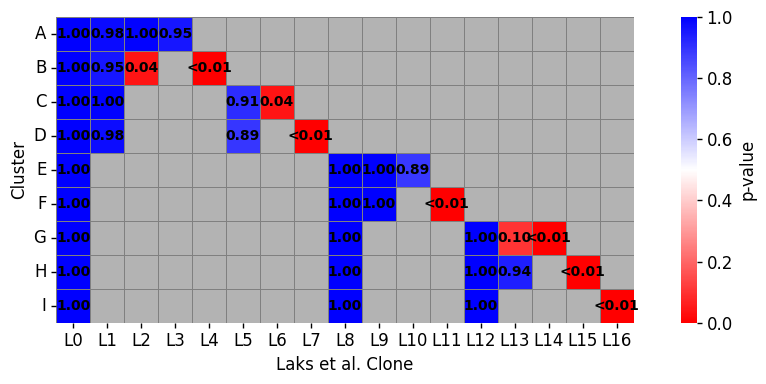

In [71]:
df = pd.DataFrame(pvals_laks_combined, index=list("ABCDEFGHI"))


def format_pval(p, threshold=0.01):
    if p < threshold:
        return f"<{threshold:.2f}"
    else:
        return f"{p:.2f}"
    
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
    "axes.linewidth": 1,  # thin axes
    "lines.linewidth": 1, # thin box lines
    "grid.color": "none",  # no grid
    "xtick.major.width": 1,
    "ytick.major.width": 1,
})


row_cols_set = set(row_cols_laks)

mask = np.ones(df.shape, dtype=bool)
for i, j in row_cols_set:
    if i < df.shape[0] and j < df.shape[1]:  # safety check
        mask[i, j] = False  # show these cells

mask_df = pd.DataFrame(mask, index=df.index, columns=df.columns)
col_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
# col_order = [0, 1, 2, 5, 8, 9, 12, 13]
df = df.reindex(columns=col_order)
mask_df = mask_df.reindex(columns=col_order)
mask = mask_df.to_numpy()

df_formatted = df.map(format_pval)


cmap = LinearSegmentedColormap.from_list("red_white_blue", ["red", "white", "blue"])
# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(
    df, 
    annot=df_formatted, 
    fmt='',
    cmap=cmap,
    mask=mask,             # mask cells not in row_cols
    cbar_kws={'label': 'p-value'},
    linewidths=0.5,        # optional grid lines
    linecolor='gray',
    vmin=0,              # force colormap to span 0->1
    vmax=1,
    annot_kws={"weight": "bold", "fontsize": 10, 'color': 'black'}
)

mask = np.flip(mask, axis=0)
plt.imshow( mask, cmap=plt.cm.Greys, alpha=mask * 0.3, zorder=-1, extent=[0, df.shape[1], 0, df.shape[0]] )

plt.gca().set_xticklabels([f"L{i}" for i in range(17)])
# plt.gca().set_xticklabels([f"L{i}" for i in range(17) if i not in [3, 4, 6, 7, 10, 11,  14, 15, 16]])

plt.yticks(rotation=0)
plt.xlabel("Laks et al. Clone")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig("../outputs/figures/laks-p-values.png", dpi=600, bbox_inches='tight',pad_inches=0.2)
plt.show()